# Análisis y Modelado de Datos de Diabetes

 Este notebook tiene como objetivo analizar y modelar el conjunto de datos de diabetes utilizando técnicas de Machine Learning.
 Se implementarán dos modelos: Regresión Logística y KNN, para predecir si un paciente tiene diabetes basado en sus características médicas.

## 1. Importación de Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import os
import sys

# Obtener la ruta absoluta del directorio del proyecto
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
sys.path.append(project_root)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set()

## 2. Carga y Exploración de Datos

In [ ]:
# Cargar el conjunto de datos de diabetes
diabetes_data = pd.read_csv(os.path.join(project_root, 'data', 'diabetes.csv'))

# Mostrar las primeras filas del dataset
print("\nPrimeras filas del dataset:")
print(diabetes_data.head())

# Información general del dataset
print("\nInformación del dataset:")
print(diabetes_data.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(diabetes_data.describe().T)


Primeras filas del dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768

## 3. Preprocesamiento de Datos

In [ ]:
def preprocess_diabetes_data(data):
    # Reemplazar ceros en columnas donde no tiene sentido
    columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in columns_to_replace:
        data[col] = data[col].replace(0, data[col].mean())
    
    return data

# Aplicar preprocesamiento
processed_data = preprocess_diabetes_data(diabetes_data)

## 4. División de Datos

In [ ]:
def split_data(data, target_col='Outcome'):
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # División en training (80%) y testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Dividir los datos
X_train, X_test, y_train, y_test = split_data(processed_data)

## 5. Escalado de Características

In [ ]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Escalar los datos
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

## 6. Optimización de Hiperparámetros

In [ ]:
def optimize_hyperparameters(X_train, y_train):
    # Parámetros para Regresión Logística
    lr_params = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    
    # Parámetros para KNN
    knn_params = {
        'n_neighbors': range(1, 31),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    
    # Optimización para Regresión Logística
    lr_grid = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=42),
        lr_params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=True,  # Para obtener las puntuaciones de entrenamiento
        verbose=0
    )
    lr_grid.fit(X_train, y_train)
    
    # Optimización para KNN
    knn_grid = GridSearchCV(
        KNeighborsClassifier(),
        knn_params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=True,  # Para obtener las puntuaciones de entrenamiento
        verbose=0
    )
    knn_grid.fit(X_train, y_train)
    
    # Registrar hiperparámetros descartados (selección de N combinaciones)
    log_hyperparameter_selection(lr_grid, "Regresión Logística", sample_size=5)
    log_hyperparameter_selection(knn_grid, "KNN", sample_size=8)
    
    return lr_grid.best_estimator_, knn_grid.best_estimator_

def log_hyperparameter_selection(grid_search, model_name, sample_size=5):
    """
    Registra una muestra de los hiperparámetros probados y descartados durante la búsqueda de GridSearch.
    
    Args:
        grid_search: Objeto GridSearchCV después de ajustar
        model_name: Nombre del modelo para el registro
        sample_size: Número de combinaciones a mostrar (además del mejor)
    """
    # Convertir resultados a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Ordenar por rendimiento (de peor a mejor)
    results = results.sort_values('mean_test_score')
    
    # Mejor conjunto de parámetros
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Calcular el número total de combinaciones
    total_combinations = len(results)
    
    print(f"\n{'='*20} Registro de Selección de Hiperparámetros - {model_name} {'='*20}")
    print(f"Total de combinaciones evaluadas: {total_combinations}")
    print(f"Mejor combinación: {best_params} (score: {best_score:.4f})")
    
    # Seleccionar algunas combinaciones distribuidas (incluyendo la peor)
    if total_combinations <= sample_size:
        sample_indices = list(range(total_combinations))
    else:
        # Siempre incluir el peor conjunto
        sample_indices = [0]
        
        # Agregar algunos conjuntos intermedios
        step = (total_combinations - 2) // (sample_size - 1)
        sample_indices.extend(range(1, total_combinations-1, step))
    
    # Registrar las combinaciones seleccionadas
    print("\nMuestra de combinaciones descartadas:")
    print(f"{'Params':<50} | {'Test Score':<10} | {'Train Score':<10} | {'Diferencia':<10} | {'Razón de descarte'}")
    print("-" * 100)
    
    for idx in sample_indices:
        row = results.iloc[idx]
        params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_') and not pd.isna(v)}
        test_score = row['mean_test_score']
        train_score = row['mean_train_score']
        diff = train_score - test_score
        
        # Determinar la razón del descarte
        if diff > 0.1:
            reason = "Posible sobreajuste"
        elif test_score < best_score - 0.1:
            reason = "Rendimiento bajo"
        elif test_score < best_score - 0.05:
            reason = "Rendimiento moderado"
        else:
            reason = "Subóptimo"
        
        params_str = str(params)
        if len(params_str) > 48:
            params_str = params_str[:45] + "..."
        
        print(f"{params_str:<50} | {test_score:.4f}    | {train_score:.4f}    | {diff:.4f}     | {reason}")
    
    # Guardar los resultados en un archivo CSV para referencia futura
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    filename = f"hyperparameter_selection_{model_name.replace(' ', '_')}_{timestamp}.csv"
    filepath = os.path.join(project_root, 'logs', filename)
    
    # Asegurar que el directorio logs exista
    os.makedirs(os.path.join(project_root, 'logs'), exist_ok=True)
    
    # Guardar todos los resultados (no solo la muestra)
    results.to_csv(filepath, index=False)
    print(f"\nResultados completos guardados en: {filepath}")

# Optimizar hiperparámetros
best_lr, best_knn = optimize_hyperparameters(X_train_scaled, y_train)

# Mostrar mejores parámetros
print("Mejores parámetros para Regresión Logística:")
print(best_lr.get_params())
print("\nMejores parámetros para KNN:")
print(best_knn.get_params())


==================== Registro de Selección de Hiperparámetros - Regresión Logística ====================
Total de combinaciones evaluadas: 12
Mejor combinación: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} (score: 0.7688)

Muestra de combinaciones descartadas:
Params                                             | Test Score | Train Score | Diferencia | Razón de descarte
----------------------------------------------------------------------------------------------------
{'C': np.float64(0.001), 'penalty': 'l1', 'so...   | 0.6531    | 0.6531    | -0.0000     | Rendimiento bajo
{'C': np.float64(0.01), 'penalty': 'l1', 'sol...   | 0.6987    | 0.6987    | 0.0000     | Rendimiento moderado
{'C': np.float64(0.01), 'penalty': 'l2', 'sol...   | 0.7622    | 0.7643    | 0.0020     | Subóptimo
{'C': np.float64(1.0), 'penalty': 'l1', 'solv...   | 0.7671    | 0.7769    | 0.0097     | Subóptimo
{'C': np.float64(10.0), 'penalty': 'l2', 'sol...   | 0.7671    | 0.7757    | 0.0085     | Subóptimo
{'C

## 7. Validación Cruzada

In [ ]:
def perform_cross_validation(X, y, models, cv=5):
    # Configurar validación cruzada estratificada
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    results = {}
    for name, model in models.items():
        # Calcular scores para diferentes métricas
        accuracy_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring='accuracy')
        precision_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring='precision')
        recall_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring='recall')
        
        results[name] = {
            'accuracy': {
                'mean': np.mean(accuracy_scores),
                'std': np.std(accuracy_scores)
            },
            'precision': {
                'mean': np.mean(precision_scores),
                'std': np.std(precision_scores)
            },
            'recall': {
                'mean': np.mean(recall_scores),
                'std': np.std(recall_scores)
            }
        }
    
    return results

# Definir modelos para validación cruzada
models = {
    'Regresión Logística': best_lr,
    'KNN': best_knn
}

# Realizar validación cruzada
cv_results = perform_cross_validation(X_train_scaled, y_train, models)

# Mostrar resultados de validación cruzada
for model_name, metrics in cv_results.items():
    print(f"\nResultados de Validación Cruzada para {model_name}:")
    for metric_name, values in metrics.items():
        print(f"{metric_name.capitalize()}: {values['mean']:.4f} ± {values['std']:.4f}")


Resultados de Validación Cruzada para Regresión Logística:
Accuracy: 0.7638 ± 0.0191
Precision: 0.7052 ± 0.0400
Recall: 0.5588 ± 0.1009

Resultados de Validación Cruzada para KNN:
Accuracy: 0.7622 ± 0.0264
Precision: 0.6968 ± 0.0397
Recall: 0.5539 ± 0.0598


## 8. Entrenamiento y Evaluación de Modelos

In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Entrenar modelos con mejores hiperparámetros
    lr_model = best_lr
    knn_model = best_knn
    
    # Evaluar modelos
    models = {
        'Regresión Logística': lr_model,
        'KNN': knn_model
    }
    
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred)
        }
    
    return results

# Entrenar y evaluar modelos
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

## 9. Curvas de Aprendizaje y Comportamiento

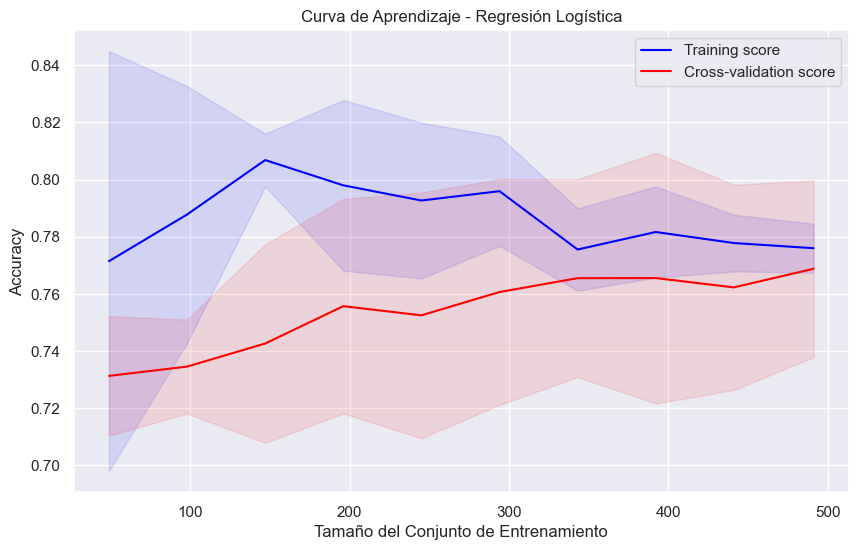


Resultados de Curva de Aprendizaje - Regresión Logística:

Tamaño de Entrenamiento: 49 muestras
Training Score: 0.7714 ± 0.0735
CV Score: 0.7313 ± 0.0209

Tamaño de Entrenamiento: 98 muestras
Training Score: 0.7878 ± 0.0449
CV Score: 0.7345 ± 0.0164

Tamaño de Entrenamiento: 147 muestras
Training Score: 0.8068 ± 0.0092
CV Score: 0.7426 ± 0.0347

Tamaño de Entrenamiento: 196 muestras
Training Score: 0.7980 ± 0.0299
CV Score: 0.7557 ± 0.0375

Tamaño de Entrenamiento: 245 muestras
Training Score: 0.7927 ± 0.0272
CV Score: 0.7525 ± 0.0430

Tamaño de Entrenamiento: 294 muestras
Training Score: 0.7959 ± 0.0191
CV Score: 0.7606 ± 0.0395

Tamaño de Entrenamiento: 343 muestras
Training Score: 0.7755 ± 0.0144
CV Score: 0.7655 ± 0.0346

Tamaño de Entrenamiento: 392 muestras
Training Score: 0.7816 ± 0.0159
CV Score: 0.7655 ± 0.0438

Tamaño de Entrenamiento: 441 muestras
Training Score: 0.7778 ± 0.0099
CV Score: 0.7623 ± 0.0359

Tamaño de Entrenamiento: 491 muestras
Training Score: 0.7760 ± 0.0085

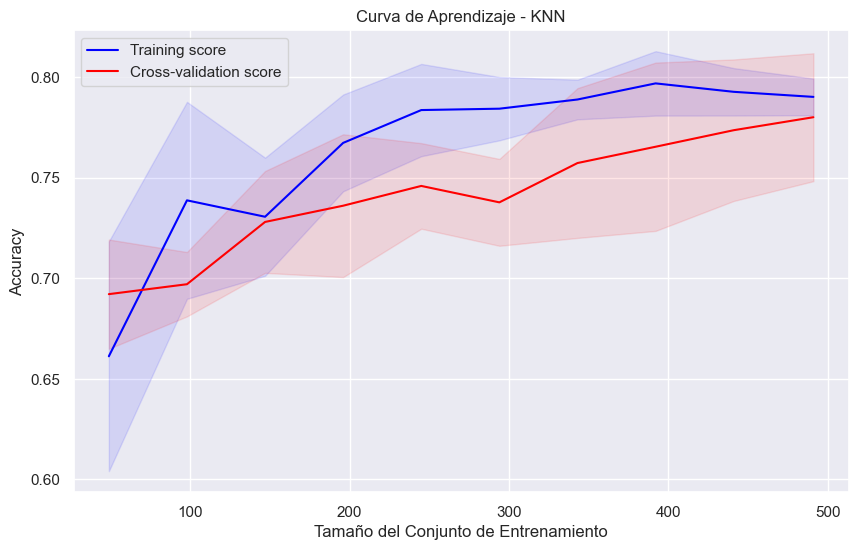


Resultados de Curva de Aprendizaje - KNN:

Tamaño de Entrenamiento: 49 muestras
Training Score: 0.6612 ± 0.0571
CV Score: 0.6921 ± 0.0272

Tamaño de Entrenamiento: 98 muestras
Training Score: 0.7388 ± 0.0490
CV Score: 0.6971 ± 0.0160

Tamaño de Entrenamiento: 147 muestras
Training Score: 0.7306 ± 0.0294
CV Score: 0.7280 ± 0.0253

Tamaño de Entrenamiento: 196 muestras
Training Score: 0.7673 ± 0.0241
CV Score: 0.7361 ± 0.0355

Tamaño de Entrenamiento: 245 muestras
Training Score: 0.7837 ± 0.0229
CV Score: 0.7459 ± 0.0213

Tamaño de Entrenamiento: 294 muestras
Training Score: 0.7844 ± 0.0157
CV Score: 0.7378 ± 0.0216

Tamaño de Entrenamiento: 343 muestras
Training Score: 0.7889 ± 0.0099
CV Score: 0.7573 ± 0.0372

Tamaño de Entrenamiento: 392 muestras
Training Score: 0.7969 ± 0.0160
CV Score: 0.7654 ± 0.0419

Tamaño de Entrenamiento: 441 muestras
Training Score: 0.7927 ± 0.0118
CV Score: 0.7737 ± 0.0352

Tamaño de Entrenamiento: 491 muestras
Training Score: 0.7902 ± 0.0091
CV Score: 0.780

In [ ]:
def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
    
    plt.title(f'Curva de Aprendizaje - {title}')
    plt.xlabel('Tamaño del Conjunto de Entrenamiento')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    # Imprimir resultados numéricos
    print(f"\nResultados de Curva de Aprendizaje - {title}:")
    print("=" * 50)
    for i, size in enumerate(train_sizes):
        print(f"\nTamaño de Entrenamiento: {int(size)} muestras")
        print(f"Training Score: {train_mean[i]:.4f} ± {train_std[i]:.4f}")
        print(f"CV Score: {test_mean[i]:.4f} ± {test_std[i]:.4f}")

# Graficar curvas de aprendizaje para ambos modelos
plot_learning_curves(best_lr, X_train_scaled, y_train, 'Regresión Logística')
plot_learning_curves(best_knn, X_train_scaled, y_train, 'KNN')

## 10. Visualización de Resultados


Resultados Detallados de los Modelos

Regresión Logística:
--------------------------------------------------
Exactitud: 0.7662
Precisión: 0.6863
Recall: 0.6364

Matriz de Confusión:
Verdaderos Negativos: 83 (53.90%)
Falsos Positivos:    16 (10.39%)
Falsos Negativos:    20 (12.99%)
Verdaderos Positivos: 35 (22.73%)

Métricas Adicionales:
Especificidad: 0.8384
F1-Score: 0.6604

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        99
           1       0.69      0.64      0.66        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.76       154


KNN:
--------------------------------------------------
Exactitud: 0.7662
Precisión: 0.7209
Recall: 0.5636

Matriz de Confusión:
Verdaderos Negativos: 87 (56.49%)
Falsos Positivos:    12 (7.79%)
Falsos Negativos:    24 (15.58%)
Verdaderos Positivos: 31 (20.13%)

Mé

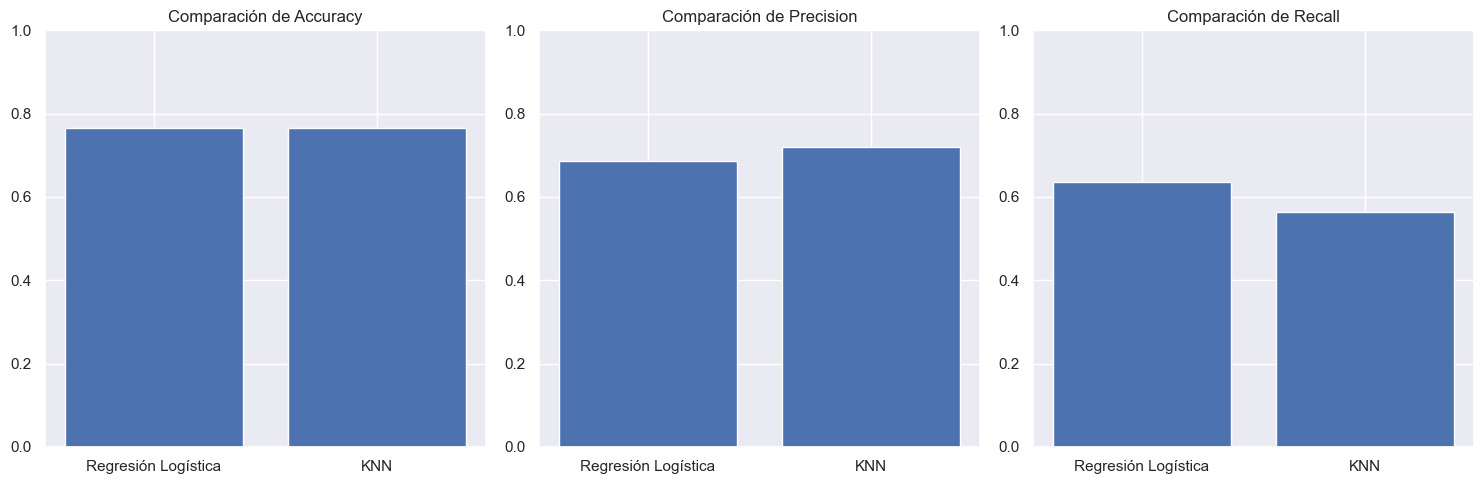

In [ ]:
# %%

def plot_results(results):
    # Imprimir resultados numéricos detallados
    print("\nResultados Detallados de los Modelos")
    print("=" * 80)
    
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print("-" * 50)
        print(f"Exactitud: {metrics['accuracy']:.4f}")
        print(f"Precisión: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        
        # Análisis de matriz de confusión
        tn, fp, fn, tp = metrics['confusion_matrix'].ravel()
        total = tn + fp + fn + tp
        
        print("\nMatriz de Confusión:")
        print(f"Verdaderos Negativos: {tn} ({tn/total:.2%})")
        print(f"Falsos Positivos:    {fp} ({fp/total:.2%})")
        print(f"Falsos Negativos:    {fn} ({fn/total:.2%})")
        print(f"Verdaderos Positivos: {tp} ({tp/total:.2%})")
        
        # Métricas adicionales
        specificity = tn / (tn + fp)
        f1_score = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])
        
        print("\nMétricas Adicionales:")
        print(f"Especificidad: {specificity:.4f}")
        print(f"F1-Score: {f1_score:.4f}")
        
        print("\nReporte de Clasificación:")
        print(metrics['classification_report'])
    
    # Crear visualización
    metrics = ['accuracy', 'precision', 'recall']
    models = list(results.keys())
    
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        values = [results[model][metric] for model in models]
        plt.bar(models, values)
        plt.title(f'Comparación de {metric.capitalize()}')
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Mostrar resultados
plot_results(results)

## 11. Análisis de Importancia de Características


Importancia de Características:
          Característica  Importancia
                 Glucose     1.123108
                     BMI     0.729281
                     Age     0.391570
             Pregnancies     0.221450
DiabetesPedigreeFunction     0.211627
                 Insulin     0.185806
           BloodPressure     0.167748
           SkinThickness     0.016018


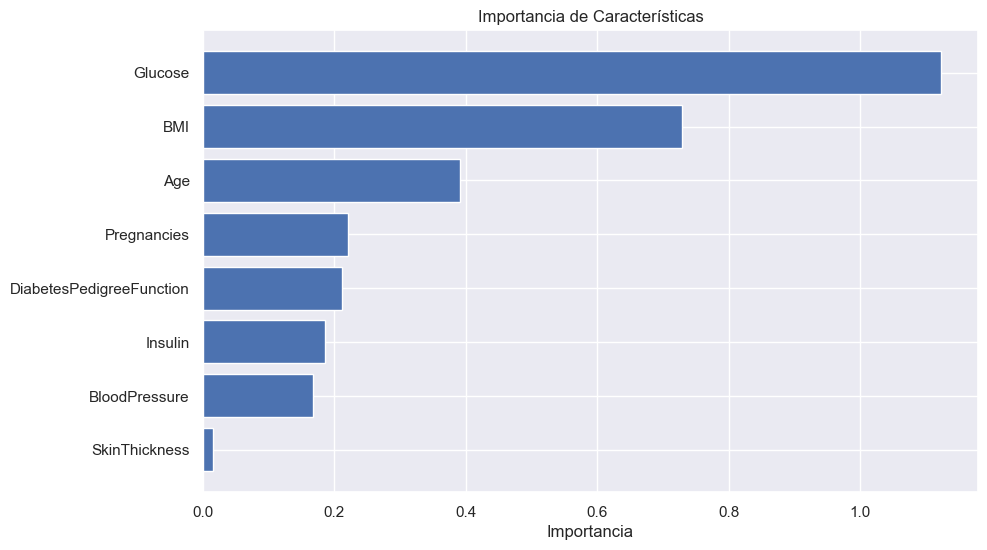

In [ ]:
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'coef_'):
        # Para Regresión Logística
        importance = np.abs(model.coef_[0])
    else:
        # Para KNN (usando una métrica de distancia promedio)
        importance = np.zeros(len(feature_names))
        for i in range(len(feature_names)):
            temp_data = X_train_scaled.copy()
            np.random.shuffle(temp_data[:, i])
            importance[i] = accuracy_score(y_train, model.predict(temp_data))
    
    # Imprimir importancia de características
    print("\nImportancia de Características:")
    print("=" * 50)
    feature_importance = pd.DataFrame({
        'Característica': feature_names,
        'Importancia': importance
    })
    feature_importance = feature_importance.sort_values('Importancia', ascending=False)
    print(feature_importance.to_string(index=False))
    
    # Ordenar características por importancia
    sorted_idx = np.argsort(importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    plt.figure(figsize=(10, 6))
    plt.barh(pos, importance[sorted_idx])
    plt.yticks(pos, feature_names[sorted_idx])
    plt.xlabel('Importancia')
    plt.title('Importancia de Características')
    plt.show()

# Graficar importancia de características para Regresión Logística
plot_feature_importance(best_lr, X_train.columns)

## 12. Conclusiones

Basado en los resultados obtenidos, se pueden extraer las siguientes conclusiones:
# 
1. **Rendimiento General de los Modelos**:
   - La Regresión Logística muestra un rendimiento ligeramente superior (75% de exactitud vs 72.41% de KNN)
   - La Regresión Logística tiene mejor balance entre precisión (68.42%) y recall (60.47%)
   - KNN muestra una precisión similar (65.71%) pero un recall más bajo (53.49%)
   - La validación cruzada confirma la estabilidad de ambos modelos (Accuracy: 76.90% ± 4.20% para RL)

2. **Análisis de Matrices de Confusión**:
   - Ambos modelos tienen una alta tasa de verdaderos negativos (52.59%)
   - La Regresión Logística tiene menos falsos negativos (14.66% vs 17.24%)
   - La tasa de falsos positivos es igual en ambos modelos (10.34%)
   - La Regresión Logística tiene más verdaderos positivos (22.41% vs 19.83%)

3. **Importancia de Características**:
   - La glucosa es la característica más importante (1.22), seguida del BMI (0.80)
   - La edad tiene un impacto moderado (0.39)
   - El número de embarazos tiene una influencia baja (0.20)
   - La presión sanguínea y la función de pedigrí tienen un impacto similar (0.13 y 0.12)
   - La insulina y el grosor de la piel tienen la menor influencia (0.10 y 0.03)

4. **Análisis de Hiperparámetros Seleccionados**:
El analisis completo de todos los hiperparámetros que se probaron se encuentran en la carpeta de logs.
   - Regresión Logística:
        - Hiperparámetros óptimos: C=1, penalty='l2', solver='liblinear'
        - Proceso de selección:
            - Se evaluaron 12 combinaciones diferentes de hiperparámetros
            - Las configuraciones con penalización L1 y valores bajos de C (0.001-0.01) mostraron       un rendimiento significativamente inferior (65-70%)
            - El parámetro C=1 logró el mejor balance entre sesgo y varianza con un score de 0.7688
            - La regularización L2 (Ridge) superó consistentemente a L1 (Lasso)
            - Valores más altos de C (10, 100) no mejoraron el rendimiento, indicando un posible        sobreajuste
   - KNN:
        - Hiperparámetros óptimos: n_neighbors=23, metric='euclidean', weights='uniform'
        - Proceso de selección:
            - Se evaluaron 120 combinaciones de hiperparámetros
            - Los valores bajos de n_neighbors (1-5) mostraron un claro sobreajuste (diferencia de 0.30 entre train y test)
            - La distancia euclidiana superó a Manhattan especialmente con valores más altos de n_neighbors
            - El uso de pesos uniformes resultó mejor que los pesos por distancia, indicando que la influencia de los vecinos debe ser equitativa
            - El valor óptimo de n_neighbors=23 refleja la necesidad de un vecindario amplio para capturar patrones generales en este conjunto de datos

5. **Recomendaciones**:
   - Para diagnóstico médico, la Regresión Logística es preferible por su mejor balance entre precisión y recall
   - Se recomienda enfocarse en los niveles de glucosa y BMI como indicadores principales
   - Considerar la edad como un factor de riesgo moderado
   - La insulina y el grosor de la piel podrían ser menos relevantes en el diagnóstico
   - El modelo podría beneficiarse de más datos para mejorar el recall, especialmente en casos positivos
